In [1]:
# setup
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

# Predicting house prices: A regression problem

In [2]:
from tensorflow.keras.datasets import boston_housing

In [3]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

```
Samples contain 13 attributes of houses at different locations around the
Boston suburbs in the late 1970s. Targets are the median values of
the houses at a location (in k$)
```

In [4]:
train_data.shape

(404, 13)

In [5]:
test_data.shape

(102, 13)

In [6]:
type(train_data)

numpy.ndarray

In [7]:
train_data[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

So, we have 13 numerical features, each with a different scale. 

In [8]:
train_targets[:5]

array([15.2, 42.3, 50. , 21.1, 17.7])

In [9]:
train_targets.shape

(404,)

In [10]:
pd.Series(train_targets).describe()

count    404.000000
mean      22.395050
std        9.210442
min        5.000000
25%       16.675000
50%       20.750000
75%       24.800000
max       50.000000
dtype: float64

## Preparing the data:

In [11]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

In [12]:
train_data

array([[-0.27224633, -0.48361547, -0.43576161, ...,  1.14850044,
         0.44807713,  0.8252202 ],
       [-0.40342651,  2.99178419, -1.33391162, ..., -1.71818909,
         0.43190599, -1.32920239],
       [ 0.1249402 , -0.48361547,  1.0283258 , ...,  0.78447637,
         0.22061726, -1.30850006],
       ...,
       [-0.40202987,  0.99079651, -0.7415148 , ..., -0.71712291,
         0.07943894, -0.67776904],
       [-0.17292018, -0.48361547,  1.24588095, ..., -1.71818909,
        -0.98764362,  0.42083466],
       [-0.40422614,  2.04394792, -1.20161456, ..., -1.30866202,
         0.23317118, -1.15392266]])

In [13]:
test_data -= mean
test_data /= std

## Building and training the model

we’ll use a very small model with two intermediate layers, each with 64 units.

In [14]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="rmsprop",
                 loss="mse",
                 metrics=["mae"])
    return model

In [15]:
# K-fold validation
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print(f"Processing fold #{i}")
    # prepares the validation data: data from partition #k
    val_data = train_data[i * num_val_samples:(i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    # prepares the training data: data from all other partitions
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                         train_data[(i +1 ) * num_val_samples:]],
                                        axis=0
                                       )
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                         train_targets[(i + 1) * num_val_samples:]],
                                           axis=0
                                          )
    model = build_model() # builds the Keras model (already compiled)
    model.fit(partial_train_data, partial_train_targets,
             epochs=num_epochs, batch_size=16, verbose=0) # train the model(in silent mode, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0) # evaluate the model on the val data
    all_scores.append(val_mae)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [16]:
all_scores

[1.8875246047973633, 2.338747978210449, 2.385051965713501, 2.298783779144287]

In [17]:
np.mean(all_scores)

2.2275270819664

As we can see, the validation scores vary from 1.93 to 2.54. 

Therefore it is much more reliable to consider the average of all scores than any single score, thats the entire point of K-fold cross-validation.

In this case, we are off by `$2400` on average which is significant considering that the prices range from `$5,000` to `$50,000`.

Lets train the model a bit longer, by setting `epochs=500`.
We will also track model performance per epoch.

In [18]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i}")
    # prepares the validation data: data from partition #k
    val_data = train_data[i * num_val_samples:(i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    # prepares the training data: data from all other partitions
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                         train_data[(i + 1) * num_val_samples:]],
                                        axis=0
                                       )
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                         train_targets[(i + 1) * num_val_samples:]],
                                           axis=0
                                          )
    model = build_model() # builds the Keras model (already compiled)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0) # train the model(in silent mode, verbose=0)
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [19]:
len(all_mae_histories)
# 4 folds of data, with val_errors per epoch with per fold

4

In [20]:
len(all_mae_histories[0])

500

In [21]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
# this gives us the average MAE per epoch considering all folds.

In [22]:
len(average_mae_history)

500

In [23]:
average_mae_history[:5]

[19.0461368560791,
 15.412515640258789,
 11.015793800354004,
 7.525450587272644,
 5.451468586921692]

Let us plot average MAE score per epoch Vs epoch:

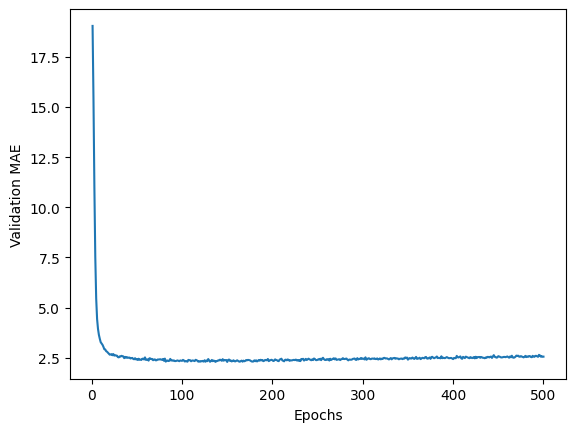

In [24]:
plt.plot(np.arange(1, num_epochs + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Lets omit the first 10 data points as there MAE values are way higher than the rest. 

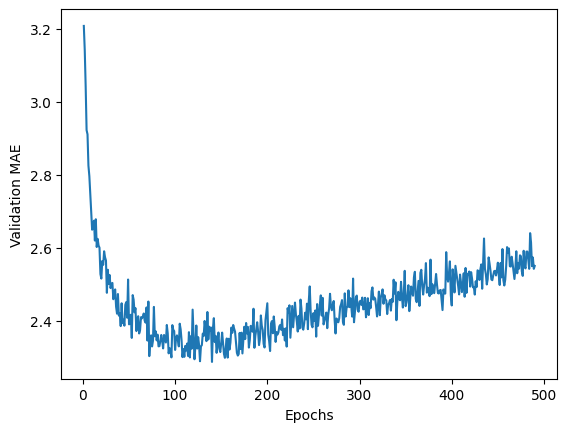

In [25]:
truncated_mae_history = average_mae_history[10:]
plt.plot(np.arange(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Validation MAE stops improving significantly after 120–140 epochs (this number includes the 10 epochs we omitted). Past that point, we start overfitting.

### Training the final model

In [31]:
model = build_model()
model.fit(train_data, train_targets,
         epochs=120, batch_size=16, verbose=0) # training on the entire train set
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.3463 - mae: 2.4927


In [32]:
test_mae_score

2.68200421333313

We are off by a bit under $2500.

**generating predictions on new data:**

In [28]:
predictions = model.predict(test_data)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [29]:
predictions[:5]

array([[ 8.711067],
       [19.56071 ],
       [22.218937],
       [32.43603 ],
       [25.720955]], dtype=float32)

In [30]:
test_targets[:5]

array([ 7.2, 18.8, 19. , 27. , 22.2])